# **SmartBasket 360: Customer Segmentation & Sales Intelligence Using RFM & CLTV**

## **Project Overview**

SmartBasket 360 is a business-focused data analytics project built using the UCI Online Retail dataset. The goal is to analyze e-commerce transaction data to uncover customer behavior, segment users, and identify revenue opportunities. The project integrates key performance indicators (KPIs) such as Customer Lifetime Value (CLTV), RFM (Recency, Frequency, Monetary) segmentation, average basket size, and sales trends. The final deliverable is an interactive dashboard built in Tableau, designed for business decision-makers in e-commerce and digital marketing.

## **Objectives**

* Understand Customer Behavior through RFM analysis to group customers by engagement and value.

* Analyze Revenue Trends over time to detect seasonal patterns, sales cycles, and high-performing regions/products.

* Estimate Customer Lifetime Value (CLTV) to prioritize marketing and retention efforts toward high-value customers.

* Measure Average Basket Size to assess purchasing habits and order value.

* Visualize Geographic Insights by analyzing sales distribution across countries.

* Deliver a Business-Ready Dashboard that transforms raw transactional data into actionable insights.

## **The Dataset**

The project uses the Online Retail dataset from the UCI Machine Learning Repository, which contains real-world transactional data from a UK-based online retailer.

The company mainly sells unique all-occasion gifts and many customers of the company are wholesalers.



**Dataset Summary**:

* Source: [UCI Machine Learning Repository – Online Retail Dataset](https://archive.ics.uci.edu/dataset/352/online+retail)

* Introductory Paper: [Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining](https://www.semanticscholar.org/paper/Data-mining-for-the-online-retail-industry%3A-A-case-Chen-Sain/e43a5a90fa33d419df42e485099f8f08badf2149)

* Timeframe: December 2010 – December 2011

* Records: 541909 transactions

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing Required Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip install squarify
import squarify
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from scipy.stats import ttest_ind

## **Loading Dataset**

In [3]:
retail_data = pd.read_csv(r"/content/drive/MyDrive/Online_Retail.csv")

## **Initial Data Analysis (IDA)**

In [4]:
# Row and Column Count
retail_data.shape

(541909, 8)

In [5]:
# Summary of the dataset
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Checking data in the first five rows of the dataset
retail_data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
# Checking the unique values in each column
retail_data.nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


In [8]:
# Exclude CustomerID
data = retail_data.drop('CustomerID', axis=1)

# Descriptive statistics for numerical columns
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [9]:
# Check for null values
retail_data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [10]:
# Check for duplicate rows
duplicates = retail_data.duplicated().sum()
print('Number of Duplicates: ', duplicates)

Number of Duplicates:  5268


Initial analysis highlights few problems,

* The data type for the column 'CustomerID' is incorrect.
* The data type for the column 'InvoiceDate' is incorrect and contains both date and time.
* Missing values are present in columns 'Description' and 'CustomerID'.
* Duplicates are present in the dataset.

### **Dataset Cleaning**

In [11]:
# Removing duplicates
retail_data = retail_data.drop_duplicates()

In [12]:
# Creating new columns for Date and Time based features
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])
retail_data['InvoiceDay'] = pd.to_datetime(retail_data['InvoiceDate']).dt.day.convert_dtypes()
retail_data['InvoiceMonth'] = pd.to_datetime(retail_data['InvoiceDate']).dt.month.convert_dtypes()
retail_data['InvoiceYear'] = pd.to_datetime(retail_data['InvoiceDate']).dt.year.convert_dtypes()
retail_data['InvoiceHour'] = pd.to_datetime(retail_data['InvoiceDate']).dt.hour.convert_dtypes()

In [13]:
# Checking the columns
retail_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceDay', 'InvoiceMonth',
       'InvoiceYear', 'InvoiceHour'],
      dtype='object')

Transactions with missing CustomerID were assumed to be from guest users and were excluded from customer-centric metrics such as CLTV and RFM segmentation. However, they were retained for aggregate sales analysis where applicable.

In [14]:
# Copying the dataframe before dropping missing values
sales_data = retail_data

In [15]:
# Dropping missing values
retail_data = retail_data.dropna()

In [16]:
# Ensure all missing values were droppped
retail_data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
InvoiceDay,0
InvoiceMonth,0


In [17]:
# Changing the column 'CustomerID' to integer
retail_data['CustomerID'] = retail_data['CustomerID'].astype(int)

<ipython-input-17-1b670d29e07f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_data['CustomerID'] = retail_data['CustomerID'].astype(int)


## **Exploratory Data Analysis (EDA)**

In [18]:
# Checking value counts of 'InvoiceNo'
retail_data['InvoiceNo'].value_counts()

,count
InvoiceNo,
576339,542
579196,533
580727,529
578270,442
573576,435
...,...
C566782,1
C566779,1
C566775,1


In [19]:
# Further analysing the rows associated with 'InvoiceNo' column starting with 'C'
C_rows = retail_data['InvoiceNo'].str.startswith('C')
canceled_orders = retail_data[C_rows]
canceled_orders.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceMonth,InvoiceYear,InvoiceHour
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,1,12,2010,9
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,1,12,2010,9
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,1,12,2010,10
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,1,12,2010,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,1,12,2010,10


Values in the 'InvoiceNo' column starting with 'C' are Cancelled Orders. These are not included in Sales metrics as they do not represent actual revenue.

As observed the 'Quantity' column contains negative values. Including them in the dataset will lead to Basket size issues and CLTV and RFM distortions.

In [20]:
# Removing Cancelled Orders
retail_data = retail_data[~C_rows]

In [21]:
# Check for rows with negative Quantity
negative_quantity = retail_data[retail_data['Quantity'] < 0]

# Check for rows with negative UnitPrice
negative_unit_price = retail_data[retail_data['UnitPrice'] < 0]

print(f"Negative Quantity rows: {len(negative_quantity)}")
print(f"Negative UnitPrice rows: {len(negative_unit_price)}")

Negative Quantity rows: 0
Negative UnitPrice rows: 0


In [22]:
# function to visualise the outliers of the columns
def visualize_outliers_boxplot(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()

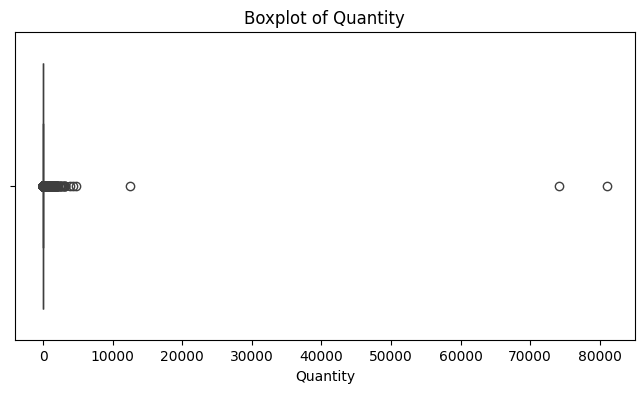

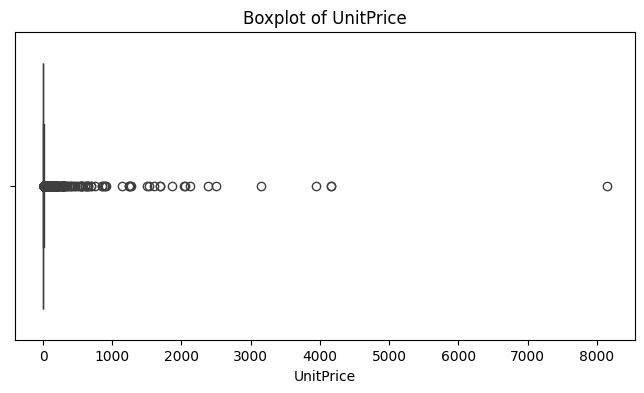

In [23]:
cols_to_check = ['Quantity', 'UnitPrice']

# Boxplots for visual outliers
visualize_outliers_boxplot(retail_data, cols_to_check)

Eventhough outliers in the columns 'Quantity' and 'UnitPrice' can be acceptable, due to the fact that the dataset includes customers who are wholesalers, the extreme values will distort metrics.

In [24]:
# A function that detects and removes outliers from specified columns using the IQR method.
def remove_outliers_iqr(df, columns, factor=1.5, remove=True, return_outliers=False):
    df_clean = df.copy()
    outliers_all = pd.DataFrame()

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outliers_all = pd.concat([outliers_all, outliers])

        if remove:
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    if return_outliers:
        return df_clean, outliers_all.drop_duplicates()
    return df_clean

In [25]:
# Columns to check for outliers
cols_to_check = ['Quantity', 'UnitPrice']

# Removing outliers from specified columns
cleaned_data, outlier_rows = remove_outliers_iqr(retail_data, cols_to_check, return_outliers=True)

print("Cleaned data shape:", cleaned_data.shape)
print("Outliers found:", outlier_rows.shape[0])

Cleaned data shape: (333265, 12)
Outliers found: 59467


In [26]:
# Creating 'Total Price' column
retail_data['TotalPrice'] = retail_data['UnitPrice'] * retail_data['Quantity']

### **Sales Trends & Product Insights - Exploratory Visualisations**

In [79]:
# Count of different products in the dataset
pd.options.display.max_rows = 400
retail_data['Description'].value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2016
REGENCY CAKESTAND 3 TIER,1714
JUMBO BAG RED RETROSPOT,1615
ASSORTED COLOUR BIRD ORNAMENT,1395
PARTY BUNTING,1390
...,...
WRAP BLUE RUSSIAN FOLKART,1
ROBIN CHRISTMAS CARD,1
LASER CUT MULTI STRAND NECKLACE,1


**Top Products by Quantity**

In [27]:
# Calculate total sales per product

product_sales = retail_data.groupby('Description').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).sort_values(by='Quantity', ascending=False)

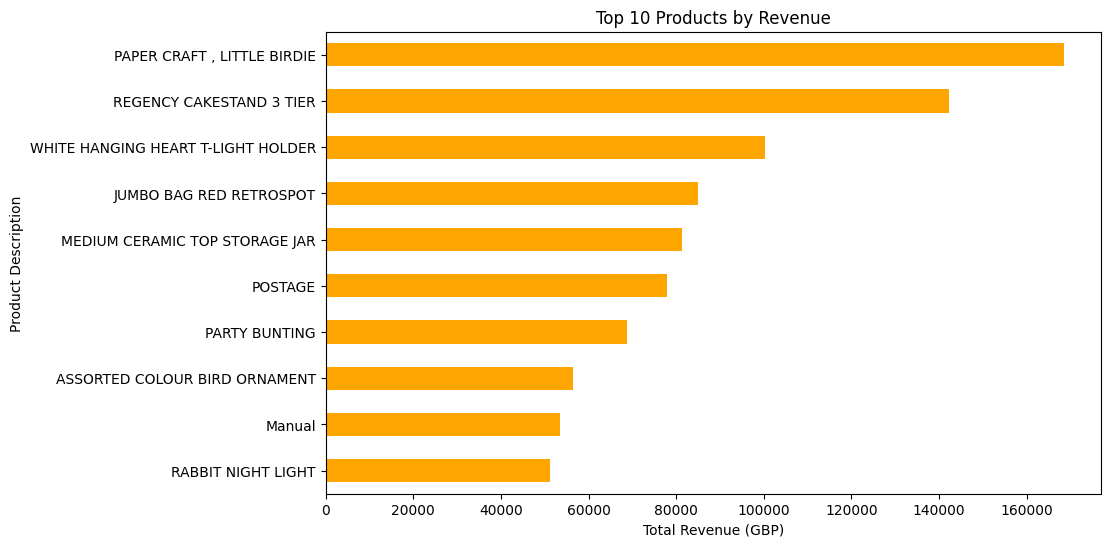

In [28]:
top_products_revenue = product_sales.sort_values(by='TotalPrice', ascending=False).head(10)

plt.figure(figsize=(10,6))
top_products_revenue['TotalPrice'].plot(kind='barh', color='orange')
plt.gca().invert_yaxis()
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (GBP)')
plt.ylabel('Product Description')
plt.show()

**Key Observations:**

* “PAPER CRAFT, LITTLE BIRDIE” is a clear standout, generating over £170,000 alone. This might likely be due to strong demand, high margins, or both.
* Bestsellers include both decorative and practical items, suggesting a healthy blend of gifting and utility-driven purchases.
* Unexpected entries like 'Manual' and 'Postage' may hint on data quality issues and require further investigation. It is worth noting that unless shipping charges are included in Revenue, it should not be a part of product sales.

**Sales by Country**

In [29]:
# Group by country and sum total sales
country_sales = retail_data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

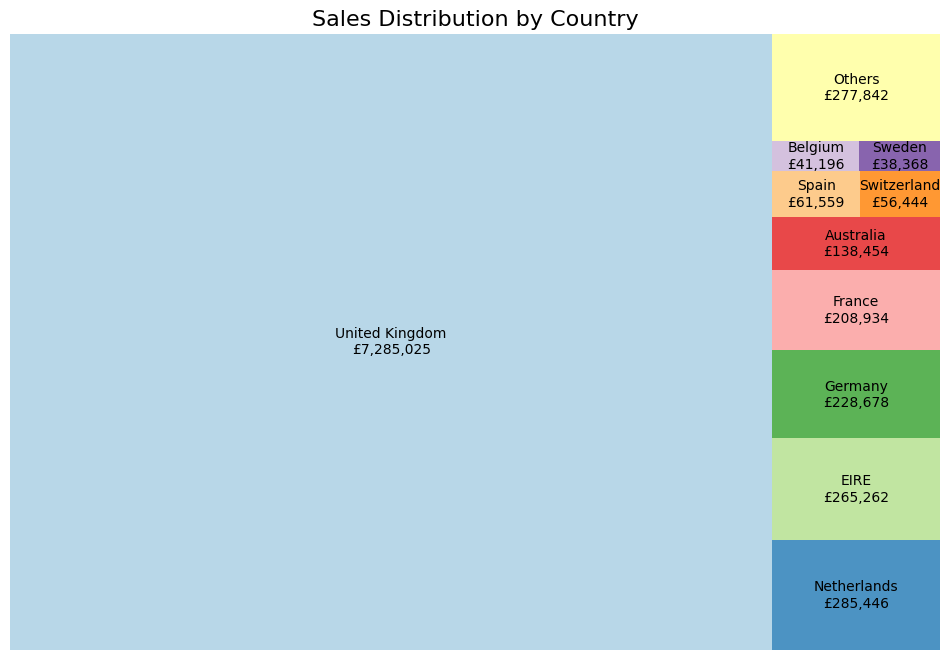

In [30]:
# Prepare data: show top 10 countries
top_n = 10
top_countries = country_sales.head(top_n)
others = country_sales.iloc[top_n:].sum()
top_countries['Others'] = others

# Data for treemap
sizes = top_countries.values
labels = [f"{country}\n£{value:,.0f}" for country, value in zip(top_countries.index, sizes)]

# Plot
plt.figure(figsize=(12,8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.Paired.colors)
plt.title('Sales Distribution by Country', fontsize=16)
plt.axis('off')
plt.show()

**Key Observations:**

* The United Kingdom accounts for the overwhelming majority of sales (£7.28M). This heavy concentration implies a strong home market but also exposes the business to domestic market risk.
* Countries like the Netherlands (£285K), EIRE/Ireland (£265K), and Germany (£228K) show solid potential. These markets could be ideal for deeper investment in marketing, localized promotions, or logistics improvements.
* France (£208K) and Australia (£138K) show promise but are underpenetrated relative to market size.

**Sales Quantity Over Time**

In [31]:
# Aggregate monthly quantity and revenue
monthly_summary = retail_data.groupby(['InvoiceYear', 'InvoiceMonth']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

# Create a datetime column
monthly_summary['YearMonth'] = pd.to_datetime(
    monthly_summary.assign(day=1)[['InvoiceYear', 'InvoiceMonth', 'day']]
    .rename(columns={'InvoiceYear': 'year', 'InvoiceMonth': 'month'})
)

# Build Plotly figure with dual y-axes
fig = go.Figure()

# Line for Quantity
fig.add_trace(go.Scatter(
    x=monthly_summary['YearMonth'],
    y=monthly_summary['Quantity'],
    mode='lines+markers',
    name='Quantity Sold',
    yaxis='y1',
    line=dict(color='royalblue')
))

# Line for Revenue
fig.add_trace(go.Scatter(
    x=monthly_summary['YearMonth'],
    y=monthly_summary['TotalPrice'],
    mode='lines+markers',
    name='Revenue',
    yaxis='y2',
    line=dict(color='seagreen')
))

# Layout with secondary y-axis
fig.update_layout(
    title='Monthly Sales Quantity and Revenue Over Time',
    xaxis=dict(
        title='Date',
        tickmode='array',
        tickvals=monthly_summary['YearMonth'],
        ticktext=monthly_summary['YearMonth'].dt.strftime('%m-%Y'),
        tickangle=45
    ),
    yaxis=dict(
        title='Quantity Sold',
        titlefont=dict(color='royalblue'),
        tickfont=dict(color='royalblue')
    ),
    yaxis2=dict(
        title='Revenue (£)',
        titlefont=dict(color='seagreen'),
        tickfont=dict(color='seagreen'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


**Key Observations:**

* There seems to be a string correlation between Quantity sold and Revenue which might also reflect limited price variability or the variability of products sold during different months.
* The sharp climb in both quantity sold and revenue in November 2011, followed by a sharp drop in December, indicates the seasonal retail pattern that aligns with the Black Friday and Christmas season.
* May–August 2011 shows a steady climb, peaking in September–November, which could align with school end-of-term events, holday prep or back-to-school prep.
* September-October increases could reflect Halloween prep.
* The lowest dip in both quantity and revenue can be observed in February which indicate lack of growth efforts during that time.

**Sales Quantity by Day of Week and Hour**

In [32]:
retail_data['InvoiceWeekday'] = retail_data['InvoiceDate'].dt.dayofweek

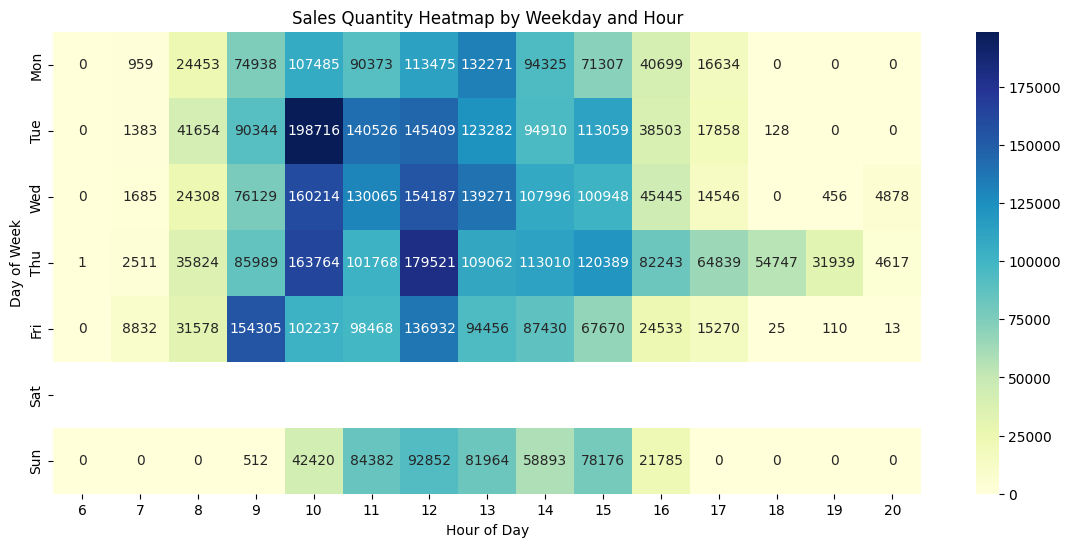

In [33]:
# Map day numbers to names
day_names = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
retail_data['WeekdayName'] = retail_data['InvoiceWeekday'].map(day_names)

# Pivot table using names instead of numbers
sales_pivot = retail_data.pivot_table(
    index='WeekdayName',
    columns='InvoiceHour',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Order the index to maintain Mon–Sun order
sales_pivot = sales_pivot.reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot
plt.figure(figsize=(14,6))
sns.heatmap(sales_pivot, cmap='YlGnBu', annot=True, fmt='.0f')

plt.title('Sales Quantity Heatmap by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


**Key Observations:**

* Most sales have happened in weekdays with some sales happening on Sunday.
* Out of weekdays, Tuesday to Friday are the busiest days highlighting Peak Operational Days.
* The highest spike is seen to be on 10AM - 10.59AM, Tuesday.
* Sales volume peaks consistently between 9:00 and 15:00.
* Almost no sales in the early mornings and evenings after 6.00PM with only an exception on Thursday with purchases happening within 6-9PM time window.




**Product Return Patterns**

In [34]:
# Identify Returned Transactions
returns = sales_data[sales_data['InvoiceNo'].str.startswith('C')]

In [35]:
returns

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceMonth,InvoiceYear,InvoiceHour
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1,12,2010,9
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1,12,2010,9
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1,12,2010,10
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,12,2010,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,12,2010,10
...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,9,12,2011,9
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,9,12,2011,10
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,9,12,2011,11
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,9,12,2011,11


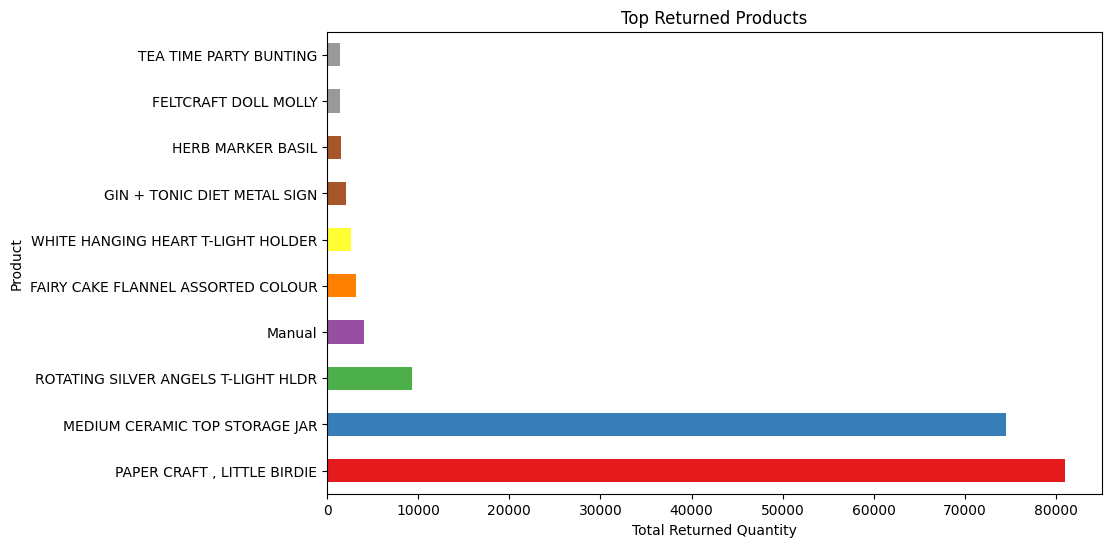

In [36]:
# Top Returned Products
top_returned_products = (
    returns.groupby('Description')['Quantity']
    .sum()
    .sort_values()
    .head(10)  # Most negatively returned
)

# Plot with absolute values
top_returned_products = top_returned_products.abs()

# Generate a list of colors from the Set1 colormap
colors = plt.cm.Set1(np.linspace(0, 1, len(top_returned_products)))

top_returned_products.plot(kind='barh', figsize=(10,6), title='Top Returned Products', color=colors)
plt.xlabel('Total Returned Quantity')
plt.ylabel('Product')
plt.show()

**Key Observations:**

* “PAPER CRAFT, LITTLE BIRDIE” and “MEDIUM CERAMIC TOP STORAGE JAR” are far outliers in return volume which might indicate return of bulk orders or data inconsistencies.
* Sharp drop in returned quantities after the major 2 products.
* Many of the returned products are decorative or novelty goods which might be seasonal or low-margin impulse buys.

<ipython-input-37-a017e6c1f437>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



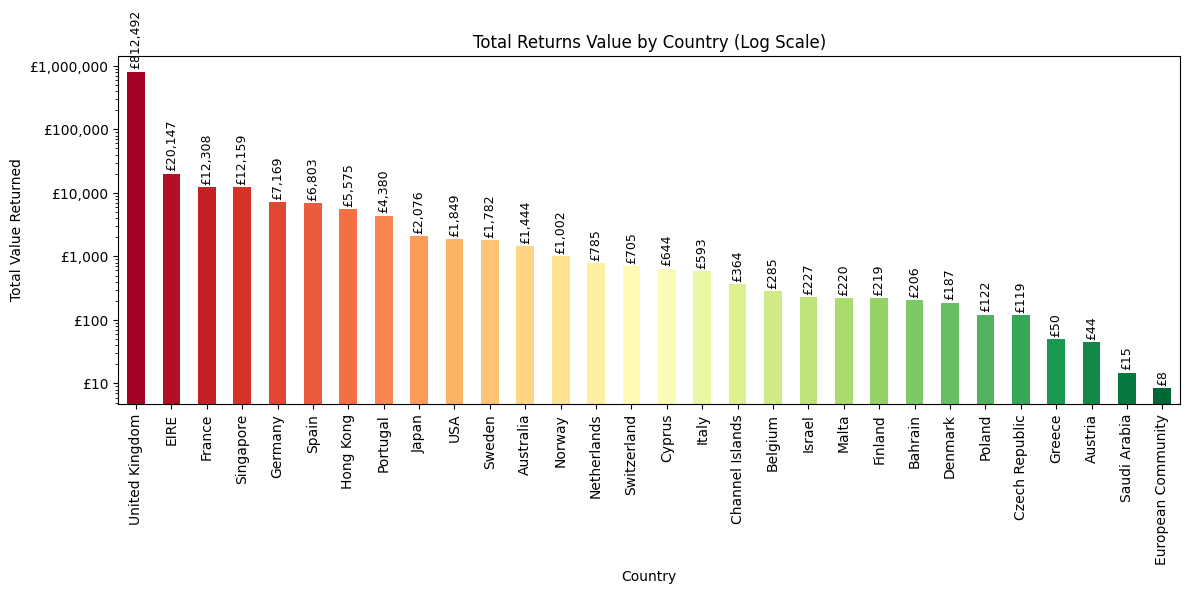

In [37]:
returns['TotalPrice'] = returns['Quantity'] * returns['UnitPrice']

# Returns by Country
returns_by_country = (
    returns.groupby('Country')['TotalPrice']
    .sum()
    .sort_values()
)

# Plot with absolute values
returns_by_country = returns_by_country.abs()

# Generate a list of colors from the RdYlGn colormap
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(returns_by_country)))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_yscale('log')

# Plot and get the bar container
bars = returns_by_country.plot(kind='bar', ax=ax, title='Total Returns Value by Country (Log Scale)', color=colors)
ax.set_ylabel('Total Value Returned')

# Format y-axis (log scale with £)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'£{y:,.0f}'))

# Add value labels on top of each bar
for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height * 1.1,  # place slightly above the bar
            f'£{height:,.0f}',
            ha='center', va='bottom', fontsize=9, rotation=90
        )

plt.tight_layout()
plt.show()

In [38]:
# Return Rate
return_rate = len(returns) / len(sales_data) * 100
print(f"Overall return rate: {return_rate:.2f}%")

Overall return rate: 1.72%


## **RFM Analysis**

**Recency**

This is the measure of how recently a customer has made a purchase. A recent purchase is a strong indicator that the customer is active and more likely to buy again.

**Frequency**

This assesses how often a customer makes a purchase. Frequent buyers are more likely to continue purchasing in the future, indicating higher loyalty, satisfaction and engagement. While infrequent purchases suggests a need for re-engagement strategies.

**Monetary Value**

This evaluates how much money a customer has spent over time. Customers who spend more are the valuable. This determines the customer's value to the business. High monetary customers contribute more to revenue, while lower spenders may require targeted strategies to increase their purchasing activity.

In [39]:
latest_date = retail_data['InvoiceDate'].max() + dt.timedelta(days = 1)

rfm = retail_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()

rfm.rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace = True)

In [40]:
#Recency score based on quantiles
#Assigning labels from 1-5,  1 being the lowest recency
rfm["Recency_score"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])

#Frequency score
rfm["Frequency_score"] = pd.qcut(rfm['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])

In [41]:
#Combine Recency and Frequency scores to create RFM Segment
rfm["rfm_segment"] = rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str)

In [42]:
rfm

,CustomerID,Recency,Frequency,MonetaryValue,Recency_score,Frequency_score,rfm_segment
0,12346,326,1,77183.60,1,1,11
1,12347,2,182,4310.00,5,5,55
2,12348,75,31,1797.24,2,3,23
3,12349,19,73,1757.55,4,4,44
4,12350,310,17,334.40,1,2,12
...,...,...,...,...,...,...,...
4334,18280,278,10,180.60,1,1,11
4335,18281,181,7,80.82,1,1,11
4336,18282,8,12,178.05,5,1,51
4337,18283,4,721,2045.53,5,5,55


In [43]:
# Creating a segment map
segment_map = {
    r'[1-2][1-2]' : 'Hibernating',
    r'[1-2][3-4]' : 'At-Risk',
    r'[1-2]5' : "Can\'t Loose",
    r'3[1-2]' : 'About to Slip',
    r'33' : 'Need Attention',
    r'[3-4][4-5]' : 'Loyal Customers',
    r'41' : 'Promising',
    r'51' : 'New Customers',
    r'[4-5][2-3]' : 'Potential Loyalists',
    r'5[4-5]' : 'Champions',
}

In [44]:
# Mapping RFM segments to corresponding customer segments
rfm['rfm_segment'] = rfm['rfm_segment'].replace(segment_map, regex = True)

In [45]:
segments = rfm['rfm_segment'].value_counts()

fig = px.bar(
     x = segments.index,
     y = segments.values,
     color = segments.index,
     text = segments.values,
     title = "RFM Segments"
)
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial")
)
fig.show()

## **Customer Lifetime Value (CLTV)**

CLTV is the total predicted revenue a business expects to earn from a customer throughout their entire relationship.

*CLTV = Monetary Value × Frequency*

**Average Order Value**

Average Order Value (AOV) shows how much a customer typically spends in a single transaction.

In [46]:
# Aggregating metrics per Customer
cltv_data = retail_data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',     # Total orders (for frequency)
    'TotalPrice': 'sum'         # Total revenue (for monetary)
}).reset_index()

# Rename
cltv_data.columns = ['CustomerID', 'TotalOrders', 'TotalRevenue']

# Average Order Value
cltv_data['AOV'] = cltv_data['TotalRevenue'] / cltv_data['TotalOrders']

**Purchase Frequency and Repeat Rate**

In [47]:
# Purchase Frequency = Total Orders / Total Customers
purchase_frequency = cltv_data['TotalOrders'].sum() / cltv_data['CustomerID'].nunique()

# Repeat Rate = Number of repeat customers / total customers
repeat_customers = cltv_data[cltv_data['TotalOrders'] > 1].shape[0]
repeat_rate = repeat_customers / cltv_data.shape[0]


**Customer Lifespan**

In [48]:
# Estimating Customer Lifespan
lifespan_df = retail_data.groupby('CustomerID').agg({
    'InvoiceDate': [min, max]
})

lifespan_df.columns = ['FirstPurchase', 'LastPurchase']
lifespan_df['CustomerLifespan'] = (lifespan_df['LastPurchase'] - lifespan_df['FirstPurchase']).dt.days

avg_lifespan = lifespan_df['CustomerLifespan'].mean() / 30  # in months


<ipython-input-48-d1f36fd8e3ec>:2: FutureWarning:

The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.

<ipython-input-48-d1f36fd8e3ec>:2: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



In [49]:
cltv_data['CLTV'] = cltv_data['AOV'] * purchase_frequency * avg_lifespan


<ipython-input-50-007a7f6f0833>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




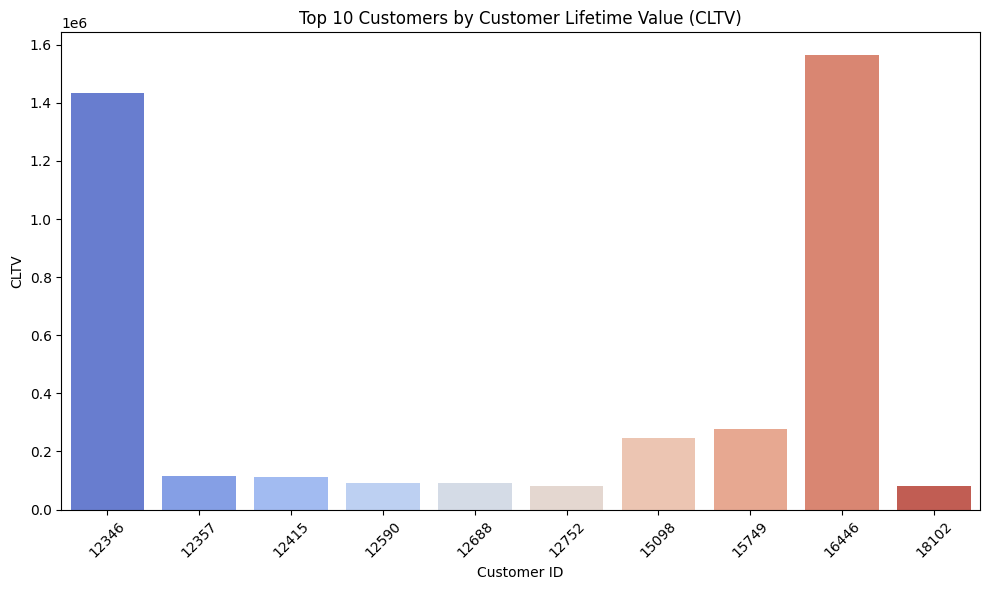

In [50]:
#Sort and select top 10
top_cltv = cltv_data.sort_values(by='CLTV', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_cltv, x='CustomerID', y='CLTV', palette='coolwarm')

plt.title('Top 10 Customers by Customer Lifetime Value (CLTV)')
plt.xlabel('Customer ID')
plt.ylabel('CLTV')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Basket Size**

The Basket size typically indicates how many items a customer typically buys per order.


**Overall Average Basket Size**

In [51]:
# Total revenue
total_revenue = retail_data['TotalPrice'].sum()

# Total number of orders (unique invoices)
total_orders = retail_data['InvoiceNo'].nunique()

# Average basket size
avg_basket_size = total_revenue / total_orders

print(f"Average Basket Size: £{avg_basket_size:.2f}")

Average Basket Size: £479.46


**Average Basket Size Per Customer**

In [52]:
basket_by_customer = retail_data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

basket_by_customer['AvgBasketSize'] = basket_by_customer['TotalPrice'] / basket_by_customer['InvoiceNo']


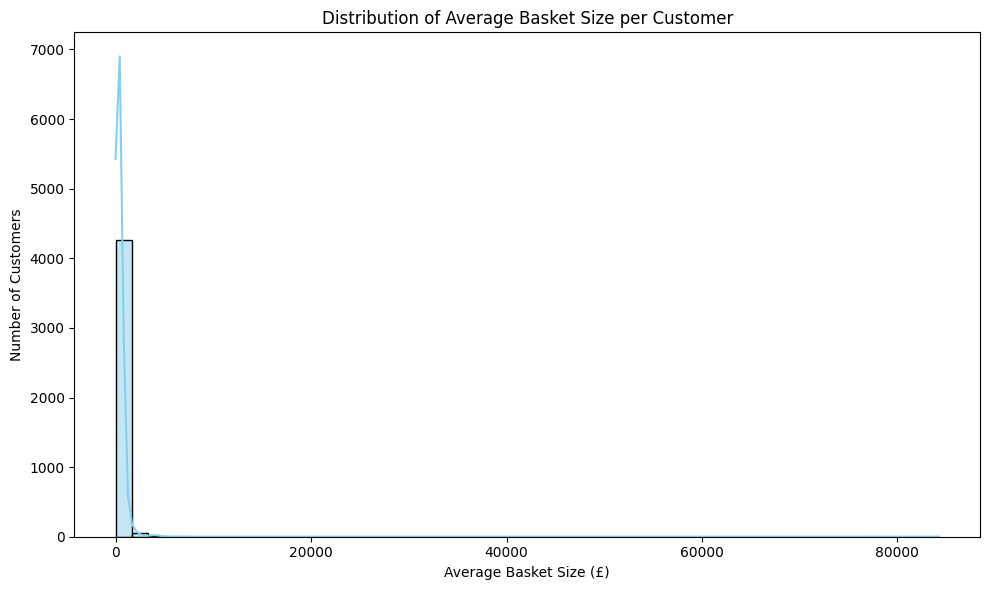

In [53]:
plt.figure(figsize=(10,6))
sns.histplot(basket_by_customer['AvgBasketSize'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Average Basket Size per Customer')
plt.xlabel('Average Basket Size (£)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


**Average Basket Size over Time**

In [54]:
# Creating 'YearMonth' column
retail_data['YearMonth'] = retail_data['InvoiceDate'].dt.to_period('M').astype(str)

In [55]:
monthly_basket = retail_data.groupby('YearMonth').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

monthly_basket['AvgBasketSize'] = monthly_basket['TotalPrice'] / monthly_basket['InvoiceNo']

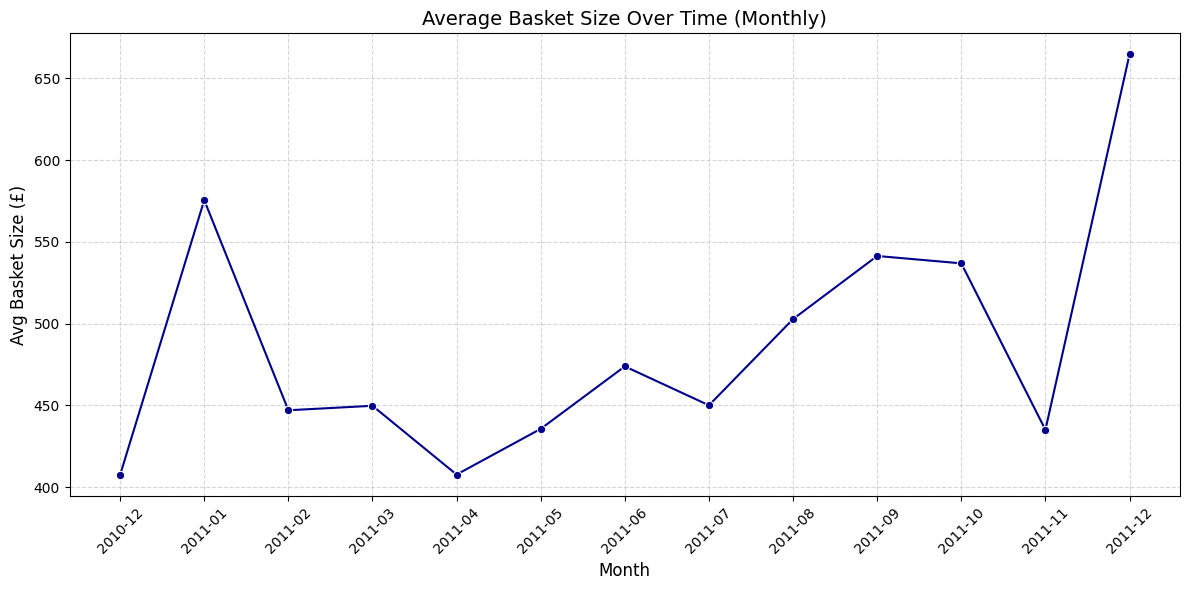

In [56]:
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_basket, x='YearMonth', y='AvgBasketSize', marker='o', color='darkblue')

plt.xticks(rotation=45)
plt.title('Average Basket Size Over Time (Monthly)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Avg Basket Size (£)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Significant peaks

## **Sales Cycles Metrics**

Sales cycles refer to patterns in customer purchasing frequency and timing.

**Time Between Purchases (Per Customer)**

In [57]:
# Sort by customer and date
retail_data = retail_data.sort_values(['CustomerID', 'InvoiceDate'])

# Calculate purchase gaps
retail_data['PrevPurchase'] = retail_data.groupby('CustomerID')['InvoiceDate'].shift(1)
retail_data['DaysBetween'] = (retail_data['InvoiceDate'] - retail_data['PrevPurchase']).dt.days

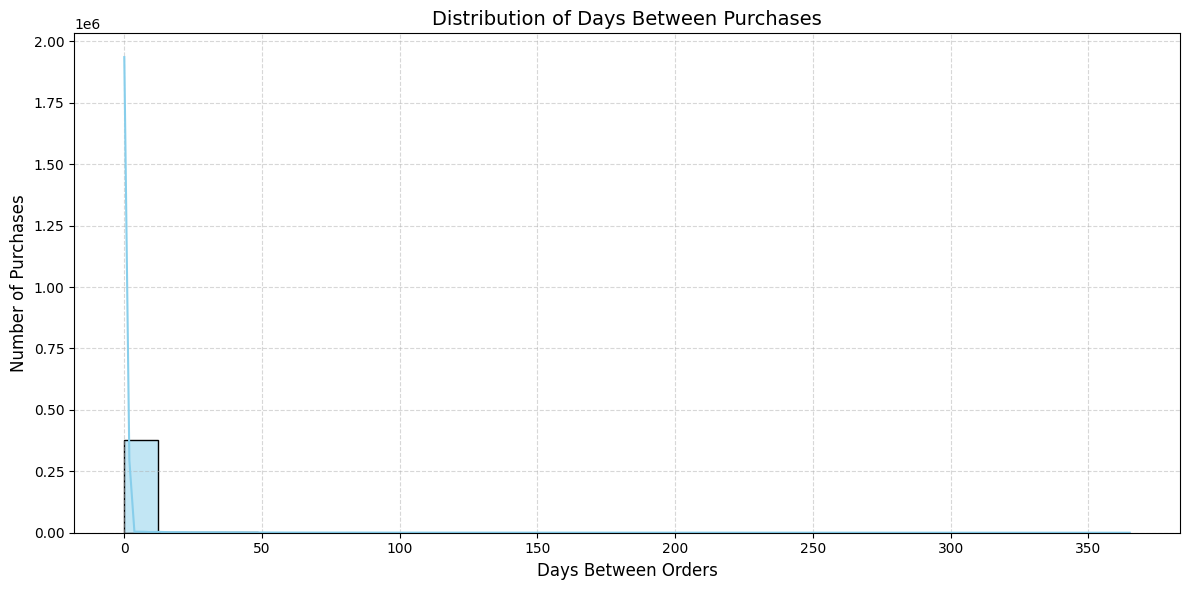

In [58]:
# Drop NaNs from first purchases
days_data = retail_data['DaysBetween'].dropna()

plt.figure(figsize=(12,6))
sns.histplot(days_data, bins=30, kde=True, color='skyblue')

plt.title('Distribution of Days Between Purchases', fontsize=14)
plt.xlabel('Days Between Orders', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [59]:
# Calculate mean/median DaysBetween per customer
intervals = retail_data.groupby('CustomerID')['DaysBetween'].agg(['mean', 'median']).dropna()

# Rename for clarity
intervals.columns = ['AvgInterval', 'MedianInterval']

# Overall stats
overall_avg = intervals['AvgInterval'].mean()
overall_median = intervals['MedianInterval'].median()

print(f"Overall Average Purchase Interval: {overall_avg:.2f} days")
print(f"Overall Median Purchase Interval: {overall_median:.2f} days")

Overall Average Purchase Interval: 3.27 days
Overall Median Purchase Interval: 0.00 days


**Customer Reorder Rate**

In [60]:
repeat_customers = retail_data.groupby('CustomerID')['InvoiceNo'].nunique()
repeat_customers

,InvoiceNo
CustomerID,
12346,1
12347,7
12348,4
12349,1
12350,1
...,...
18280,1
18281,1
18282,2


In [61]:
repeat_customers = retail_data.groupby('CustomerID')['InvoiceNo'].nunique()
repeat_rate = (repeat_customers > 1).mean()
print(f"Repeat Purchase Rate: {repeat_rate:.2%}")

Repeat Purchase Rate: 65.57%


**Customer Lifecycle Length**

Text(0.5, 0, 'Days Between First and Last Purchase')

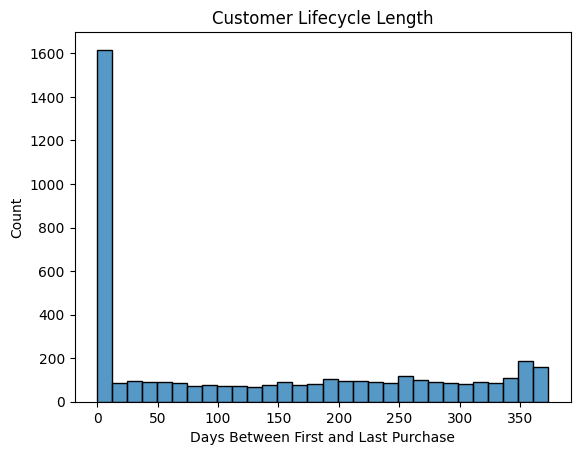

In [62]:
customer_lifecycle = retail_data.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_lifecycle['LifecycleDays'] = (customer_lifecycle['max'] - customer_lifecycle['min']).dt.days

# Plot lifecycle length distribution
sns.histplot(customer_lifecycle['LifecycleDays'], bins=30)
plt.title('Customer Lifecycle Length')
plt.xlabel('Days Between First and Last Purchase')

## **Statistical Validation & Insights**

In [63]:
# Combining CLTV and RFM metrics
rfm_cltv_data = pd.merge(rfm, cltv_data, on='CustomerID')

In [64]:
# Basket size = total quantity / number of orders per customer
customer_orders = retail_data.groupby('CustomerID')['InvoiceNo'].nunique()
customer_quantity = retail_data.groupby('CustomerID')['Quantity'].sum()
basket_size = (customer_quantity / customer_orders).reset_index(name='AvgBasketSize')

# Merge with existing df
rfm_cltv_data = pd.merge(rfm_cltv_data, basket_size, on='CustomerID')

**Correlation Insights**

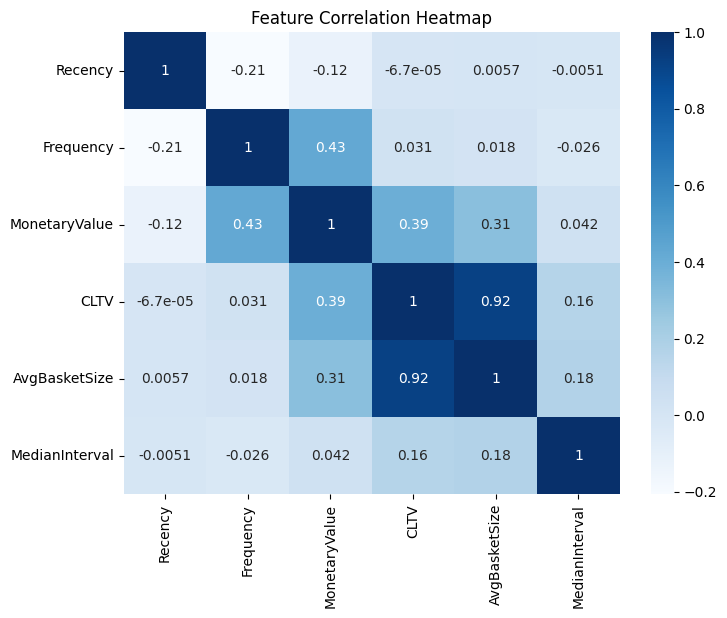

In [65]:
rfm_cltv_data = rfm_cltv_data.merge(intervals, on='CustomerID', how='left')

# Pick numerical features
corr_features = rfm_cltv_data[['Recency', 'Frequency', 'MonetaryValue', 'CLTV', 'AvgBasketSize', 'MedianInterval']]

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_features.corr(), annot=True, cmap='Blues')
plt.title('Feature Correlation Heatmap')
plt.show()

**Key Observations:**

1. **CLTV**

  CLTV vs AvgBasketSize: 0.92 (Very strong positive relationship).
  * Customers with higher basket sizes tend to have much higher lifetime value.

  CLTV vs MonetaryValue: 0.39 (Moderate positive relationship).
  * More spending = higher CLTV, which is expected.

  CLTV vs MedianInterval: 0.16 (Weak positive correlation).
  * Slight trend that customers with longer intervals might still yield high CLTV (could be big-ticket buyers).

2. **Basket Size**

  AvgBasketSize vs MonetaryValue: 0.31 (Moderate correlation).
  * High spenders usually buy more per transaction.

  AvgBasketSize vs Frequency: Very low (0.018)
  * Suggests basket size and frequency are mostly independent. Frequent buyers don’t necessarily buy more per order.

3. **Recency**

  Weak/negative correlations with all variables.
  * Recency on its own is not strongly predictive of other metrics, though still useful in RFM for recent engagement.



**Hypothesis Testing**

Do "Champion" customers have significantly higher CLTV than "At Risk" customers?

**Hypotheses:**

Null Hypothesis (H₀): There is no difference in the CLTV value between "Champion" customers and "At Risk" customers.

Alternative Hypothesis (H₁): "Champion" customers have higher CLTV than "At Risk" customers.

In [66]:
champion_cltv = rfm_cltv_data[rfm_cltv_data['rfm_segment'] == 'Champions']['CLTV']
at_risk_cltv = rfm_cltv_data[rfm_cltv_data['rfm_segment'] == 'At-Risk']['CLTV']

t_stat, p_value = ttest_ind(champion_cltv, at_risk_cltv, equal_var=False)
print("T-stat:", t_stat, "| P-value:", p_value)

if p_value < 0.05:
    print("✅ Reject H₀: /'Champion/' customers have higher CLTV than /'At Risk/' customers.")
else:
    print("❌ Fail to reject H₀: No significant difference in CLTV.")

T-stat: -0.12926043551236177 | P-value: 0.8971735508842292
❌ Fail to reject H₀: No significant difference in CLTV.


**Business Research Questions**

1. Do High CLTV Customers Come from Specific RFM Segments?

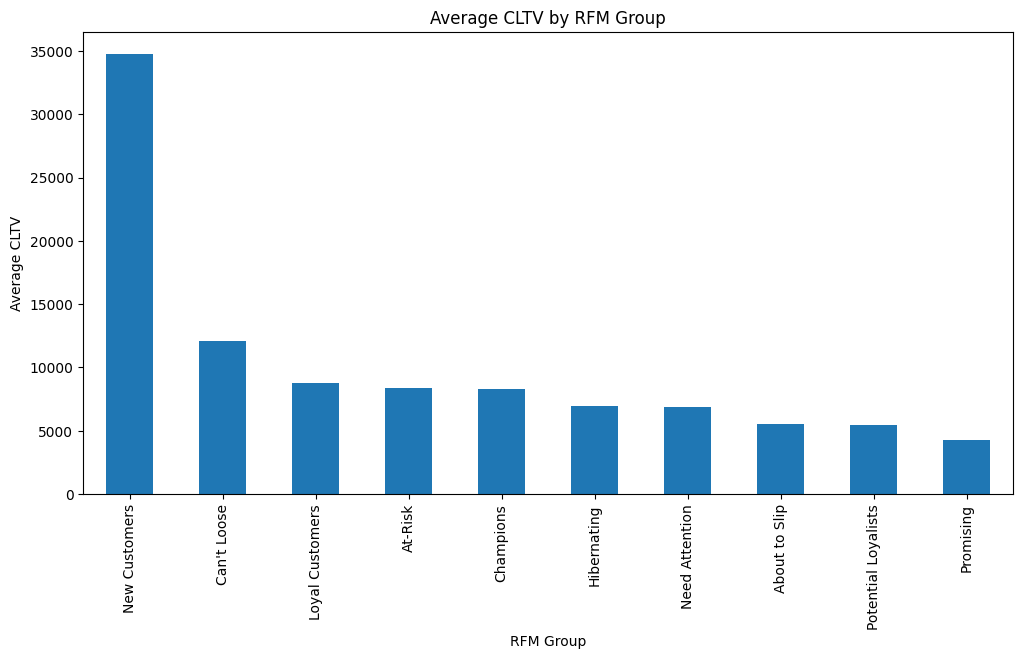

In [67]:
rfm_group_cltv = rfm_cltv_data.groupby('rfm_segment')['CLTV'].mean().sort_values(ascending=False)

rfm_group_cltv.plot(kind='bar', figsize=(12,6), title='Average CLTV by RFM Group')
plt.ylabel('Average CLTV')
plt.xlabel('RFM Group')
plt.show()

2. Do Customers Purchase More Frequently or Have Larger Baskets?



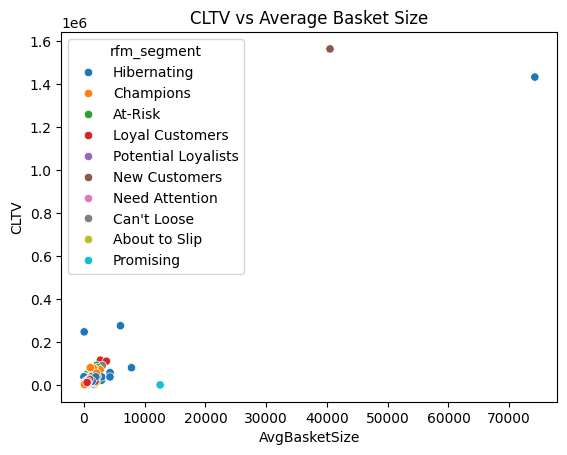

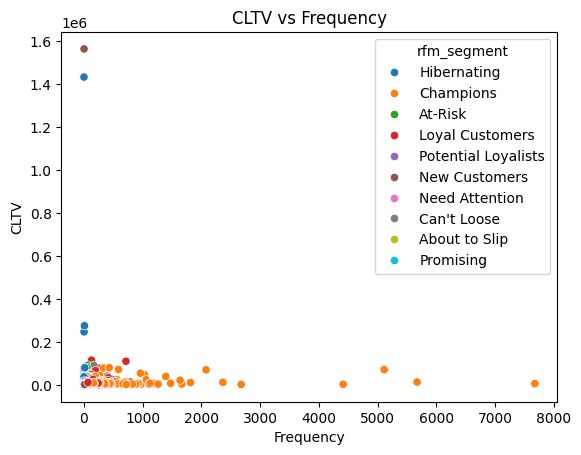

In [68]:
# CLTV vs Avg Basket Size
sns.scatterplot(data=rfm_cltv_data, x='AvgBasketSize', y='CLTV', hue='rfm_segment')
plt.title('CLTV vs Average Basket Size')
plt.show()

# CLTV vs Frequency
sns.scatterplot(data=rfm_cltv_data, x='Frequency', y='CLTV', hue='rfm_segment')
plt.title('CLTV vs Frequency')
plt.show()

3. Is the business at risk of losing high-value customers?

In [69]:
# Metrics for Risk
rfm_cltv_data['ChurnRisk'] = (
    (rfm_cltv_data['Recency'] > rfm_cltv_data['Recency'].quantile(0.75)).astype(int) +
    (rfm_cltv_data['MedianInterval'] > rfm_cltv_data['MedianInterval'].quantile(0.75)).astype(int)
)

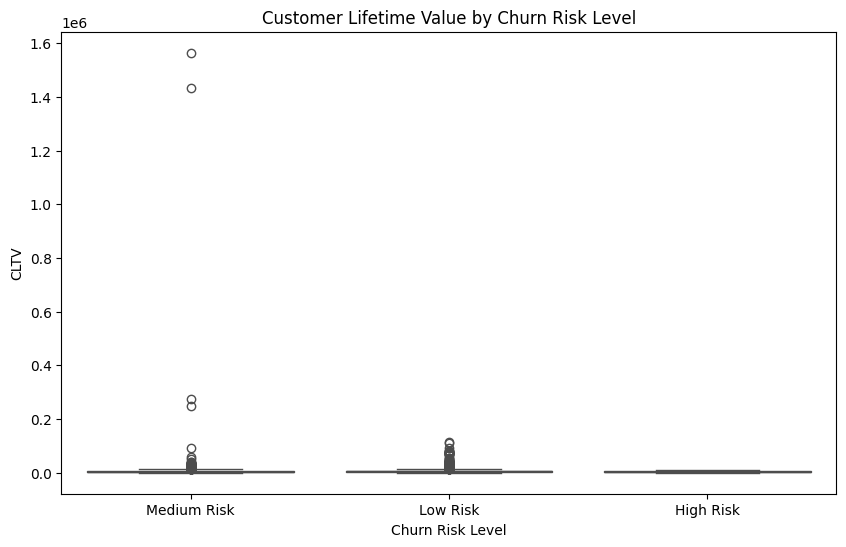

In [70]:
# Boxplot

risk_labels = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk'}
rfm_cltv_data['RiskLevel'] = rfm_cltv_data['ChurnRisk'].map(risk_labels)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='RiskLevel', y='CLTV', data=rfm_cltv_data, color='red')
plt.title('Customer Lifetime Value by Churn Risk Level')
plt.xlabel('Churn Risk Level')
plt.ylabel('CLTV')
plt.show()

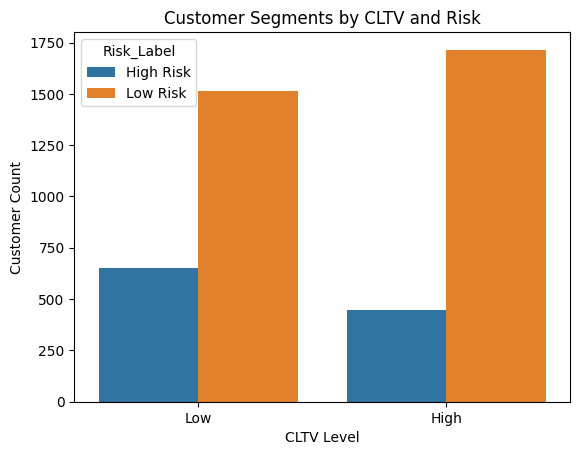

In [71]:
rfm_cltv_data['CLTV_Level'] = pd.qcut(rfm_cltv_data['CLTV'], 2, labels=['Low', 'High'])
rfm_cltv_data['Risk_Label'] = rfm_cltv_data['ChurnRisk'].map({0: 'Low Risk', 1: 'High Risk'})

sns.countplot(x='CLTV_Level', hue='Risk_Label', data=rfm_cltv_data)
plt.title("Customer Segments by CLTV and Risk")
plt.xlabel("CLTV Level")
plt.ylabel("Customer Count")
plt.show()

## **Conclusion and Future Work**


This has been a preliminary investigation of the Online Retail Dataset, aimed at understanding key customer behaviors, sales trends, and product dynamics. While the analysis provided initial insights into seasonal demand patterns, customer segmentation, product returns, and purchasing behaviors, it also opened up several avenues for deeper exploration.

As this project is being developed alongside a growing understanding of the business context, the current findings should be viewed as a foundation rather than a finished product. Future work will focus on:

* Diving deeper into customer segmentation using advanced RFM and CLTV modeling.

* Differentiating between retail and wholesale buyers using basket size thresholds.

* Investigating return patterns and product-level issues to identify operational inefficiencies.

* Exploring seasonality more rigorously — for example, aligning sales peaks with events like Christmas, Black Friday, or school holidays.

* Improving churn risk models and linking them with personalized retention strategies.

The goal is to iterate, refine, and enhance this analysis as I gain more domain knowledge and technical capability. This project will continue to evolve as a learning tool and a practical case study in applying data analytics to real-world retail challenges.

